# Demo: How to Query TxLLM for Retrieval of Custom AASeq Embeddings

In [1]:
import torch
import torch.nn.functional as F
from procyon.model.model_unified import UnifiedProCyon

[2025-02-06 15:25:44,313] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
CKPT_NAME = "MODELDIR/ProCyon-Bind"

In [3]:
# Loading the model and transitioning to device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME, load_plm_directly = True, protein_pooling_correction_option = True)
model.config.filter_negatives_by_id_contrastive = False # Need to override bc it can cause problems later - not necessary for inference
model.to(device)
model.eval()

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/REPRO/ProCyon-Instruct/
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: peptide_embeddings_path
updating stale DATA_DIR for mod

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.


embed_tokens.weight True
layers.0.self_attn.k_proj.weight True
layers.0.self_attn.k_proj.bias True
layers.0.self_attn.v_proj.weight True
layers.0.self_attn.v_proj.bias True
layers.0.self_attn.q_proj.weight True
layers.0.self_attn.q_proj.bias True
layers.0.self_attn.out_proj.weight True
layers.0.self_attn.out_proj.bias True
layers.0.self_attn_layer_norm.weight True
layers.0.self_attn_layer_norm.bias True
layers.0.fc1.weight True
layers.0.fc1.bias True
layers.0.fc2.weight True
layers.0.fc2.bias True
layers.0.final_layer_norm.weight True
layers.0.final_layer_norm.bias True
layers.1.self_attn.k_proj.weight True
layers.1.self_attn.k_proj.bias True
layers.1.self_attn.v_proj.weight True
layers.1.self_attn.v_proj.bias True
layers.1.self_attn.q_proj.weight True
layers.1.self_attn.q_proj.bias True
layers.1.self_attn.out_proj.weight True
layers.1.self_attn.out_proj.bias True
layers.1.self_attn_layer_norm.weight True
layers.1.self_attn_layer_norm.bias True
layers.1.fc1.weight True
layers.1.fc1.bia

UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128263, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
     

In [4]:
import os
HOME_DIR = os.getenv("HOME_DIR")
# Make sure this line runs, follow instructions in GitHub to set HOME_DIR

In [5]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

## Functions to set up inputs:

Below I'll define some functions that are useful to construct inputs. These create the template needed for retrieval querying, including adding the famous `[PROT]` token.

Note that these will remain the same from our previous retrieval notebook, what we'll change is the comparison to embeddings.

In [6]:
from tqdm import trange
from typing import List
from procyon.data.data_utils import DATA_DIR, get_text_sequences_compositions
from procyon.data.it_collator import construct_task_id
from procyon.data.instruct_tune.instruct_constructor import get_prompt, get_prompt_open_def
from procyon.data.data_utils import convert_batch_protein

from procyon.data.constants import QA_SUBSETS, CAPTION_SUBSETS

from esm.data import Alphabet, BatchConverter

from Bio import SeqIO

model_args = torch.load(os.path.join(CKPT_NAME, "model_args.pt"))
aaseq_tokenizer = Alphabet.from_architecture(model_args.protein_tokenizer_name)
BATCH_CONVERTER = BatchConverter(
                aaseq_tokenizer,
                truncation_seq_length = model_args.max_aaseq_len if (model_args.long_protein_strategy == "truncate") else None
            )
# To tokenize sequences:
def convert_batch_sequences(seqs):
    unique_indices = list(range(len(seqs)))
    batch_toks = convert_batch_protein(
        ids = unique_indices,
        is_protein_tokenized = False,
        batch_converter = BATCH_CONVERTER,
        protein_sequences = seqs,
        protein_tokens = None,
        protein_tokenizer = aaseq_tokenizer,
        max_protein_len = model_args.max_aaseq_len,
    )
    return batch_toks

def get_aaseq_library(seqs, batch_size = 2, output_key = "shared"):
    batch_toks = convert_batch_sequences(seqs).to(device)
    # Break into batch_size to avoid OOM's:
    batch_idx = torch.arange(0, len(seqs), step=batch_size)
    batch_gather = []
    for i in trange(batch_idx.shape[0]):
        if i == (batch_idx.shape[0] - 1):
            sub_batch_toks = batch_toks[batch_idx[i]:,:]
        else:
            sub_batch_toks = batch_toks[batch_idx[i]:batch_idx[i+1],:]
        # Call forward_sequences:
        out = model.forward_sequences(seq_input = sub_batch_toks, get_soft_tokens = False)
        batch_gather.append(out[output_key])
    return torch.cat(batch_gather, dim=0)

In [7]:
PROTEIN_SEQS = [str(seq.seq) for seq in SeqIO.parse(os.path.join(DATA_DIR, f"integrated_data/v1/protein/protein_sequences.fa"), "fasta")]
DOMAIN_SEQS = [str(seq.seq) for seq in SeqIO.parse(os.path.join(DATA_DIR, f"integrated_data/v1/domain/domain_sequences.fa"), "fasta")]
PEPTIDE_SEQS = [str(seq.seq) for seq in SeqIO.parse(os.path.join(DATA_DIR, f"integrated_data/v1/peptide/peptide_sequences.fa"), "fasta")]

In [8]:
import json
import pandas as pd
from typing import List
from procyon.data.data_utils import DATA_DIR, get_text_sequences_compositions
from procyon.data.it_collator import construct_task_id
from procyon.data.instruct_tune.instruct_constructor import get_prompt, get_prompt_open_def

from procyon.data.constants import RETRIEVAL_SUBSETS

UNIPROT_IDS = pd.read_pickle(os.path.join(DATA_DIR, "integrated_data/v1/protein/", "protein_info_filtered.pkl"))[["index", "protein_id", "name"]]

def uniprot_id_to_index(uniprot_id):
    assert (UNIPROT_IDS["protein_id"] == uniprot_id).sum() == 1, "ID {} not found in internal database".format(uniprot_id)
    i = UNIPROT_IDS["index"].loc[UNIPROT_IDS["protein_id"] == uniprot_id].item()
    return i

def index_to_uniprot_id(i):
    uniprot_id = UNIPROT_IDS["protein_id"].loc[UNIPROT_IDS["index"] == i].item()
    return uniprot_id    

The below code computes a ranking against the reference embeddings provided by the user. I'll show below how you can get those reference embeddings from our model.

In [9]:
def ranking_sim_from_embedding(model_out, reference_embeddings, top_k = 20):
    '''
    Inputs:
        model_out: dictionary
            - Of the form of output from model, accesses the query embedding as shown below
        top_k: int
            - Number of top proteins to retrieve for the scoring
            - Set this to None if you want the whole dataframe
    '''
    # Get embedding:
    query_embedding = model_out["contrastive_out"]["positive"]["text"][0,:].unsqueeze(0).detach().clone()
    query_embedding = F.normalize(query_embedding, dim=-1)

    # Now compute similarities to all proteins:
    # all_protein_embeddings might already be normalized, but in this case, normalize() is an identify function
    sims = torch.matmul(query_embedding.cuda(), F.normalize(reference_embeddings, dim=-1).transpose(0,1).cuda()).squeeze()

    # Rank distances:
    sort_inds = torch.argsort(sims, descending=True)
    if top_k is not None:
        topk_inds = sort_inds[:top_k].detach().clone().cpu().tolist()
        sim_sub= sims[sort_inds[:top_k]].detach().clone().cpu().tolist()
    else:
        topk_inds = sort_inds.detach().clone().cpu().tolist()
        sim_sub= sims[sort_inds].detach().clone().cpu().tolist()
    
    # Construct pd and print:
    df = pd.DataFrame({"index": topk_inds, "sim_score":sim_sub})

    return df

### Loading ACE2 data:

In [10]:
ace2_peptides = pd.read_csv(os.path.join(DATA_DIR, "experimental_data/ProteinPeptideBinding/ace2_peptides.csv"))

Generate embeddings for each peptide:

In [11]:
ace2_seqs = ace2_peptides["seq"].tolist()
ace2_lib = get_aaseq_library(ace2_seqs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [01:09<00:00, 37.10it/s]


In [12]:
cpu_lib = ace2_lib.cpu()

In [13]:
def create_prot_pep_input_retrieval(
        input_aaseq_seq: str,
        task_definition: str = None,
        icl_example_number: int = 1, # Only active if not providing your own icl sequences
        icl_seqs1: List[str] = None,
        icl_seqs2: List[str] = None,
    ):
    '''
    Args:
        input_description: str
            - Input description on which to query
        task_definition: str
            - If provided, this will replace the part after the "Definition: " tag in the instructions
        instruction_source_dataset: str
            - Should describe the dataset, or text type
            - Options: ["disgenet", "pfam", "drugbank", "ec", "go", "gtop", "omim", "uniprot", "reactome", "protein" (which is STRING protein-protein)]
        instruction_source_relation: str
            - Should describe the relation within that dataset
            - For most datasets, this is "all", but for some datasets you can make it more precise:
                go: "process", "function", "component"
                drugbank: "target", "carrier", "enzyme", "transporter"
                protein: "coexpression", "homology", "experiments"
        aaseq_type: str
            - Should be "protein", "domain", or later "peptide"
            - Tells the model which embedding layer we should access, i.e., embeddings for domains or proteins
            - Also important for defining the instruction - ex: domain-go vs. protein-gok
        icl_example_number: int
            - Number of in-context examples to use for the given dataset
            - We use 1 in all of our training, so recommended to set to 1
            - Options: [0, 1, 2]
    ''' 

    task_type = "retrieval"

    # Assertions to enforce structure of ICL examples:
    assert not (((icl_seqs1 is not None) and (icl_seqs2 is None)) or ((icl_seqs1 is None) and (icl_seqs2 is not None)))
    if (icl_seqs1 is not None):
        assert len(icl_seqs1) == len(icl_seqs2)

    example_descriptions = []

    instruction_source_dataset = "peptide"
    instruction_source_relation = "all"
    
    # Load instructions from instruction constructor
    task_id = construct_task_id(aaseq_type = "peptide", 
                                text_type = instruction_source_dataset, 
                                relation_type = instruction_source_relation, 
                                task_type = task_type)
    fpath = os.path.join(HOME_DIR, f"procyon/data/instruct_tune/tasks/{task_id}.json")
    
    with open(fpath, "r") as j:
        task_json = json.loads(j.read())

    get_prompt_fn = get_prompt if (task_definition is None) else get_prompt_open_def

    if icl_seqs1:
        icl_example_number = 0

    if task_definition is None:
        instruction, _, _, example_text_ids, example_aaseq_ids = get_prompt(task = task_json, 
                num_examples = icl_example_number,
                is_special_definition = False,
                is_ppi = True,
                aaseq_type = "peptide",
            )
    else:
        instruction, _, _, _, example_text_ids, example_aaseq_ids = get_prompt_open_def(task = task_json, 
                num_examples = icl_example_number,
                is_special_definition = False,
                is_ppi = True,
                aaseq_type = "peptide",
            )

        instruction = instruction.format(definition=task_definition)


    if icl_seqs1 is not None:
        insert_index = instruction.find("\n\nNow, complete the following instance:")
        assert insert_index != -1, "Not found for ICL insertion, ERROR"

        instruction_prefix = instruction[:insert_index]
        instruction_suffix = instruction[insert_index:]

        icl_seqs = []
        example_aaseq_ids = []
        for i in range(len(icl_seqs1)):
            # Create in-context text:
            # <|protein|> token is used generally to refer to a sequence of amino acids in the tokenizer
            instruction_prefix += f"\nPositive example {i+1}: Peptide 1: <|protein|> Peptide 2: <|protein|>"
            
            # Append proper sequences:
            #icl_seqs.append(PROTEIN_SEQS[icl_binding_protein_ids[i]])
            icl_seqs.append(icl_seqs1[i])
            icl_seqs.append(icl_seqs2[i])

            example_aaseq_ids.append(0) # Null index
            example_aaseq_ids.append(0)

        instruction = instruction_prefix + instruction_suffix

    else:
    
        icl_seqs = None
        if icl_example_number > 0:
            icl_seqs = [PEPTIDE_SEQS[i] for i in example_aaseq_ids]
    
    if icl_seqs is not None:
        all_seqs = icl_seqs + [input_aaseq_seq]
    else:
        all_seqs = [input_aaseq_seq]

    L = example_aaseq_ids + [0]
    unique_aaseq_indices = torch.LongTensor(L).to(device)
    input_seq_tokens = convert_batch_sequences(all_seqs).to(device)

    instruction = instruction.replace("[CONTEXT]", "")

    model_input = {
            "data": {
                "seq": input_seq_tokens,
                "seq_idx": unique_aaseq_indices,
                "text": [],
                "drug": None, # Optional
            },
            "input": {
                "seq": torch.arange((len(all_seqs))).unsqueeze(0).tolist(),
                "text": [[]], # List not tensor
                "drug": None,
                #"drug": np.arange(len(unique_drug_indices)).tolist(),
            },
            "target": { # This is only used for training
                "seq": None,
                "text": None,
                "drug": None,
            },
            "instructions": [instruction],
        }

    # return model_input
    return model_input

## Approach 1: Open-ended peptide retrieval

In [14]:
icl_proteins = [PROTEIN_SEQS[uniprot_id_to_index("Q9BYF1")], PROTEIN_SEQS[uniprot_id_to_index("Q9BYF1")]]
icl_peptides = ["LDFKQMSGWLHSK", "WHRAVVSDLLFEK"]

In [15]:
prot_peptide_input = create_prot_pep_input_retrieval(
    input_aaseq_seq = PROTEIN_SEQS[uniprot_id_to_index("Q9BYF1")],
    task_definition = None,
)

with torch.no_grad():
    model_out = model(
                    inputs = prot_peptide_input,
                    retrieval=True,
                    aaseq_type='peptide',
                    exclude_protein_structure = True,
                )

In [16]:
ace2_rankings = ranking_sim_from_embedding(model_out, ace2_lib, top_k = None)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
ace2_nb = ace2_rankings.sort_values("index")["sim_score"].loc[(ace2_peptides["binder"] == 0.0).to_numpy()]
ace2_b = ace2_rankings.sort_values("index")["sim_score"].loc[(ace2_peptides["binder"] == 1.0).to_numpy()]
df_dict = {
    'Retrieval Similarity Score': ace2_rankings.sort_values("index")["sim_score"].tolist(),
    "labels": ["Binder" if t else "Non-Binder" for t in (ace2_peptides["binder"] == 1.0).tolist()],
}
ret_results = pd.DataFrame(df_dict)

In [19]:
from scipy.stats import ttest_ind, mannwhitneyu

mannwhitneyu(ace2_nb, ace2_b)

MannwhitneyuResult(statistic=105127.0, pvalue=0.00018304499466881914)

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score

auc = roc_auc_score(ace2_peptides["binder"].astype(int), ace2_rankings.sort_values("index")["sim_score"])
print(auc)

0.6426391004024801


## Example: In-Context Examples for Protein-Peptide Binding

Now we'll tweak the task definition:

"You will be shown a protein, specifically the ACE2 protein, and a peptide. 
Here is a description of the function of ACE2: Essential counter-regulatory carboxypeptidase of the renin-angiotensin hormone system that is a critical regulator of blood volume, systemic vascular resistance, and thus cardiovascular homeostasis.
Converts angiotensin I to angiotensin 1-9, a nine-amino acid peptide with anti-hypertrophic effects in cardiomyocytes, and angiotensin II to angiotensin 1-7, which then acts as a beneficial vasodilator and anti-proliferation agent, counterbalancing the actions of the vasoconstrictor angiotensin II.
Also removes the C-terminal residue from three other vasoactive peptides, neurotensin, kinetensin, and des-Arg bradykinin, but is not active on bradykinin.
Also cleaves other biological peptides, such as apelins (apelin-13, [Pyr1]apelin-13, apelin-17, apelin-36), casomorphins (beta-casomorphin-7, neocasomorphin) and dynorphin A with high efficiency.
In addition, ACE2 C-terminus is homologous to collectrin and is responsible for the trafficking of the neutral amino acid transporter SL6A19 to the plasma membrane of gut epithelial cells via direct interaction, regulating its expression on the cell surface and its catalytic activity.
A peptide is a short strand of amino acids; in this case, the peptide will be either a binder or non-binder to the protein, ACE2.
Your job is to determine if Peptide 2 binds to Protein 1."

In [21]:
# Use just protein-protein experiments prompt:
ACE2_SEQ = PROTEIN_SEQS[uniprot_id_to_index("Q9BYF1")]
pos_prots = [ACE2_SEQ]
neg_prots = [ACE2_SEQ]
pos_peptides = ["LDFKQMSGWLHSK", ]
neg_peptides = ["LQKFLGERFPGWK", ] # Randomly chosen from the negative peptides list

task_definition = "You will be shown a protein, specifically ACE2, and a peptide. "
#desc = "Here is a description of the function of ACE2: Essential counter-regulatory carboxypeptidase of the renin-angiotensin hormone system that is a critical regulator of blood volume, systemic vascular resistance, and thus cardiovascular homeostasis. Converts angiotensin I to angiotensin 1-9, a nine-amino acid peptide with anti-hypertrophic effects in cardiomyocytes, and angiotensin II to angiotensin 1-7, which then acts as a beneficial vasodilator and anti-proliferation agent, counterbalancing the actions of the vasoconstrictor angiotensin II. Also removes the C-terminal residue from three other vasoactive peptides, neurotensin, kinetensin, and des-Arg bradykinin, but is not active on bradykinin. Also cleaves other biological peptides, such as apelins (apelin-13, [Pyr1]apelin-13, apelin-17, apelin-36), casomorphins (beta-casomorphin-7, neocasomorphin) and dynorphin A with high efficiency. In addition, ACE2 C-terminus is homologous to collectrin and is responsible for the trafficking of the neutral amino acid transporter SL6A19 to the plasma membrane of gut epithelial cells via direct interaction, regulating its expression on the cell surface and its catalytic activity. " 
peptide = "A peptide is a short strand of amino acids. In this case, the peptide will be either a binder or non-binder to the protein which means that the peptide physically interacts with the protein, ACE2, which is an essential counter-regulatory carboxypeptidase of the renin-angiotensin hormone system that is a critical regulator of blood volume, systemic vascular resistance, and thus cardiovascular homeostasis. Your job is to determine if Peptide 2 interacts with Protein 1. If the peptide binds to the protein, ACE2, output 'yes', if it does not bind, output 'no'."

In [22]:
import pickle
preds_np, labels = pickle.load(open(os.path.join(DATA_DIR, "experimental_data/ProteinPeptideBinding/ace2_preds.pickle"), "rb"))

In [23]:
# Taking difference between yes token and no token to compare sets
diff = (preds_np[:,0] - preds_np[:,1])

In [24]:
diff[labels == 0].mean()

-0.16666350695554297

In [25]:
diff[labels == 1].mean()

-0.061499518310201576

In [26]:
df_dict = {
    'Normalized "Yes" Score': diff,
    "labels": ["Binder" if l == 1 else "Non-Binder" for l in labels],
}
qa_results = pd.DataFrame(df_dict)

In [27]:
qa_results

,"Normalized ""Yes"" Score",labels
0,0.350589,Binder
1,0.072362,Binder
2,-0.013600,Binder
3,0.021777,Binder
4,-0.177427,Binder
...,...,...
5125,-0.063583,Non-Binder
5126,0.404032,Non-Binder
5127,-0.265081,Non-Binder
5128,0.329343,Non-Binder


### Combine predictions and plot results

In [28]:
sum_results = ret_results.copy()
R = ret_results["Retrieval Similarity Score"].to_numpy()
ret_norm = (R - R.min()) / (R.max() - R.min())

Q = qa_results['Normalized "Yes" Score'].to_numpy()
qa_norm = (Q - Q.min()) / (Q.max() - Q.min())

sum_results["score"] = (ret_norm + qa_norm) / 2

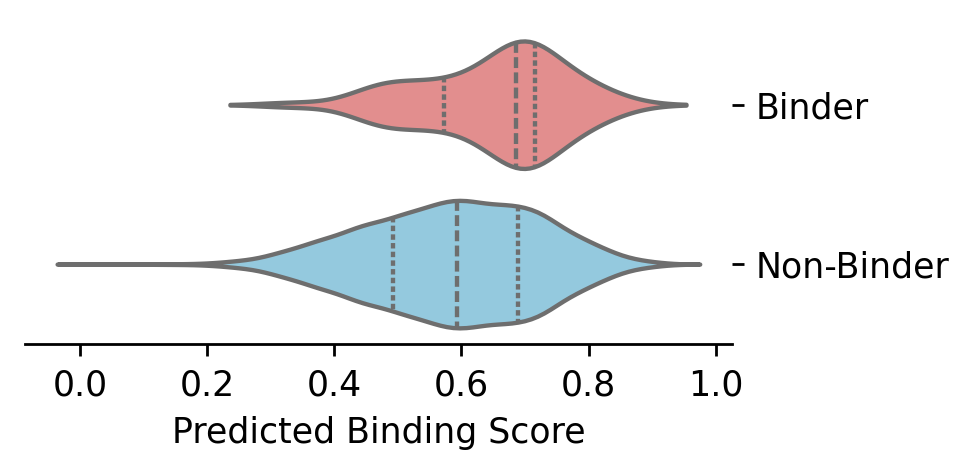

In [29]:
fig,ax = plt.subplots(dpi=250, figsize=(4,2))

sns.violinplot(sum_results, 
    #hue = "labels", 
    x = 'score', 
    y = "labels",
    hue = "labels",
    palette = {"Binder": "lightcoral", "Non-Binder": "skyblue"},
    ax=ax,
    legend=False,
    inner = "quart"
)
sns.despine(left=True)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.xlabel("Predicted Binding Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import mannwhitneyu, wilcoxon
mannwhitneyu(sum_results["score"].loc[sum_results["labels"] == "Binder"], sum_results["score"].loc[sum_results["labels"] == "Non-Binder"])

MannwhitneyuResult(statistic=190628.0, pvalue=0.00010354793262905243)

In [31]:
labels = (sum_results["labels"] == "Binder").to_numpy(int)

print("AUROC:", roc_auc_score(labels, sum_results["score"]))
print("AUPRC:", average_precision_score(labels, sum_results["score"]))

AUROC: 0.64800663548352
AUPRC: 0.017528261532023547


### ESM Baseline - as discussed in paper

In [32]:
# Try forward sequences for ESM comparison:
ace2_lib_esm = get_aaseq_library(ace2_seqs, output_key = "original")
#model.forward_sequences()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [01:01<00:00, 42.05it/s]


In [33]:
cpu_lib = ace2_lib_esm.cpu()
import pickle
#pickle.dump((cpu_lib, ace2_seqs), open("ace2_info_esm.pkl", "wb"))

In [34]:
ACE2_SEQ

'MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQQNGSSVLSEDKSKRLNTILNTMSTIYSTGKVCNPDNPQECLLLEPGLNEIMANSLDYNERLWAWESWRSEVGKQLRPLYEEYVVLKNEMARANHYEDYGDYWRGDYEVNGVDGYDYSRGQLIEDVEHTFEEIKPLYEHLHAYVRAKLMNAYPSYISPIGCLPAHLLGDMWGRFWTNLYSLTVPFGQKPNIDVTDAMVDQAWDAQRIFKEAEKFFVSVGLPNMTQGFWENSMLTDPGNVQKAVCHPTAWDLGKGDFRILMCTKVTMDDFLTAHHEMGHIQYDMAYAAQPFLLRNGANEGFHEAVGEIMSLSAATPKHLKSIGLLSPDFQEDNETEINFLLKQALTIVGTLPFTYMLEKWRWMVFKGEIPKDQWMKKWWEMKREIVGVVEPVPHDETYCDPASLFHVSNDYSFIRYYTRTLYQFQFQEALCQAAKHEGPLHKCDISNSTEAGQKLFNMLRLGKSEPWTLALENVVGAKNMNVRPLLNYFEPLFTWLKDQNKNSFVGWSTDWSPYADQSIKVRISLKSALGDKAYEWNDNEMYLFRSSVAYAMRQYFLKVKNQMILFGEEDVRVANLKPRISFNFFVTAPKNVSDIIPRTEVEKAIRMSRSRINDAFRLNDNSLEFLGIQPTLGPPNQPPVSIWLIVFGVVMGVIVVGIVILIFTGIRDRKKKNKARSGENPYASIDISKGENNPGFQNTDDVQTSF'

In [35]:
ace2_esm_embed = get_aaseq_library([ACE2_SEQ], output_key = "original")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


In [36]:
sim_esm = torch.matmul(ace2_lib_esm, ace2_esm_embed.T)

In [37]:
secpu = sim_esm.detach().clone().cpu().numpy()
auc = roc_auc_score(labels, secpu)
print("AUC:", auc)

AUC: 0.39323738170347
